In [1]:
import os
import random
import shutil
import glob
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import patches
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.ops.boxes import box_iou
from torchvision import transforms
from torchvision.models.detection.ssdlite import SSDLiteHead
from torchvision.models.detection.anchor_utils import DefaultBoxGenerator
from torchvision.ops import box_iou


Train Dataset Size: 579
Validation Dataset Size: 103


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSDLite320_MobileNet_V3_Large_Weights.COCO_V1`. You can also use `weights=SSDLite320_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/ssdlite320_mobilenet_v3_large_coco-a79551df.pth" to /root/.cache/torch/hub/checkpoints/ssdlite320_mobilenet_v3_large_coco-a79551df.pth
100%|██████████| 13.4M/13.4M [00:00<00:00, 111MB/s] 


Epoch [1/80], Loss: 521.6084
Epoch [2/80], Loss: 331.4243
Epoch [3/80], Loss: 289.6523
Epoch [4/80], Loss: 255.6084
Epoch [5/80], Loss: 225.9314
Epoch [6/80], Loss: 212.7240
Epoch [7/80], Loss: 196.5202
Epoch [8/80], Loss: 176.5607
Epoch [9/80], Loss: 165.3404
Epoch [10/80], Loss: 152.4796
Epoch [11/80], Loss: 152.8879
Epoch [12/80], Loss: 141.3931
Epoch [13/80], Loss: 129.8247
Epoch [14/80], Loss: 123.9456
Epoch [15/80], Loss: 114.1028
Epoch [16/80], Loss: 110.3035
Epoch [17/80], Loss: 104.7062
Epoch [18/80], Loss: 99.2805
Epoch [19/80], Loss: 94.9580
Epoch [20/80], Loss: 91.5849
Epoch [21/80], Loss: 90.6506
Epoch [22/80], Loss: 86.8443
Epoch [23/80], Loss: 83.1769
Epoch [24/80], Loss: 80.7966
Epoch [25/80], Loss: 76.5124
Epoch [26/80], Loss: 76.8024
Epoch [27/80], Loss: 71.6568
Epoch [28/80], Loss: 73.5124
Epoch [29/80], Loss: 66.7076
Epoch [30/80], Loss: 66.8041
Epoch [31/80], Loss: 67.1753
Epoch [32/80], Loss: 64.7358
Epoch [33/80], Loss: 63.3467
Epoch [34/80], Loss: 59.9017
Epoch 

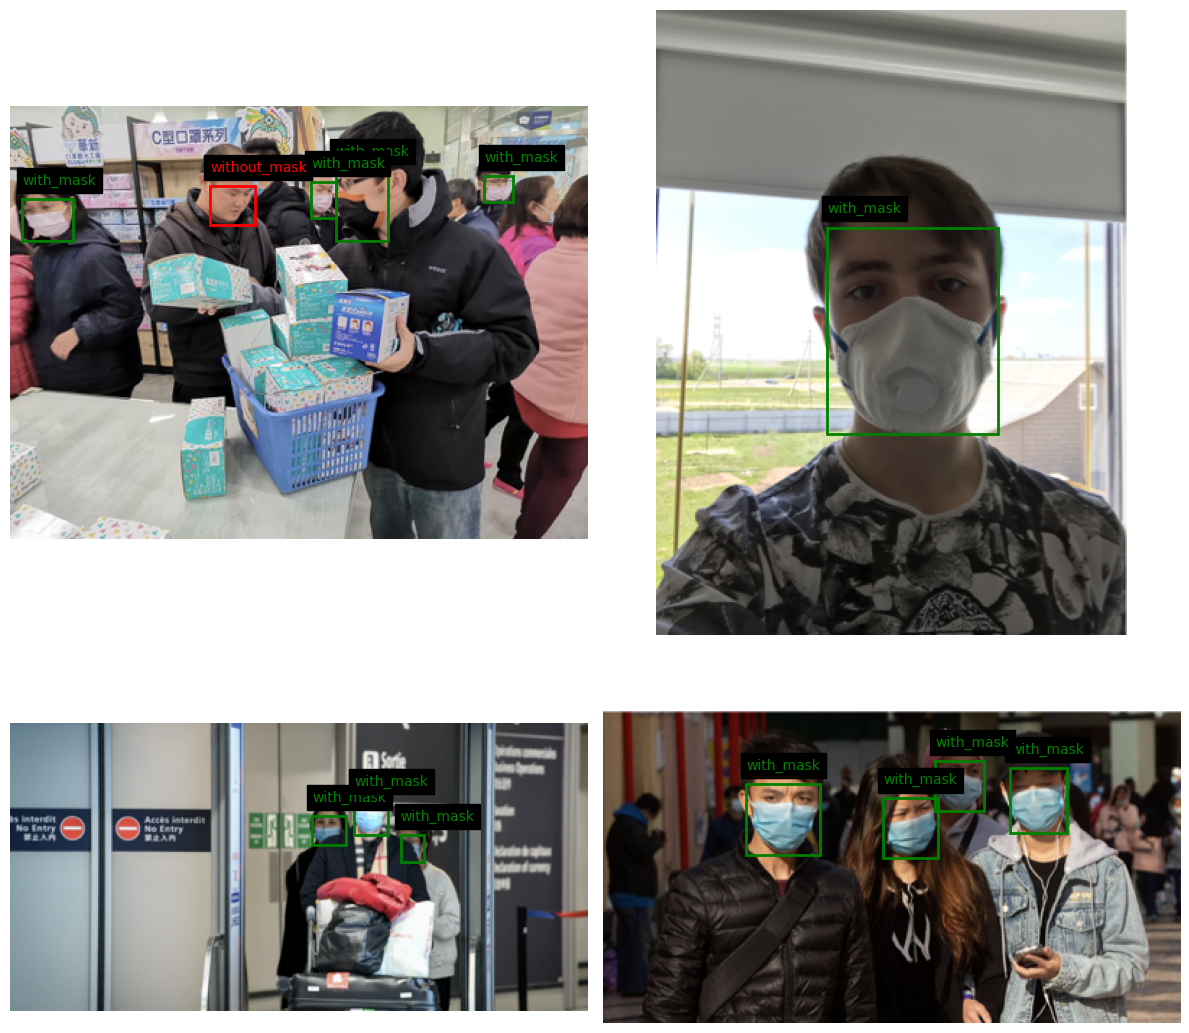

In [2]:


# Dataset Paths
directory = "/kaggle/input/face-mask-detection"  # Adjust this to your dataset path
image_directory = os.path.join(directory, "images")
annotation_directory = os.path.join(directory, "annotations")


# Class Mapping
class_id = {
    "with_mask": 0,
    "mask_weared_incorrect": 1,
    "without_mask": 2
}

# Parse Annotations
data_dict = {
    'filename': [],
    'label': [],
    'class_id': [],
    'width': [],
    'height': [],
    'bboxes': []
}
annotations = list(glob.glob(os.path.join(annotation_directory, '*.xml')))

for annotation_path in annotations:
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    filename = root.find('filename').text
    for obj in root.findall("object"):
        label = obj.find("name").text
        bbox = [
            int(obj.find("bndbox/xmin").text),
            int(obj.find("bndbox/ymin").text),
            int(obj.find("bndbox/xmax").text),
            int(obj.find("bndbox/ymax").text)
        ]
        size = root.find('size')

        data_dict['filename'].append(filename)
        data_dict['width'].append(int(size.find('width').text))
        data_dict['height'].append(int(size.find('height').text))
        data_dict['label'].append(label)
        data_dict['class_id'].append(class_id[label])
        data_dict['bboxes'].append(bbox)

df_data = pd.DataFrame(data_dict)

# Train-Test Split
train_files, test_files = train_test_split(df_data['filename'].unique(), test_size=0.2, random_state=23)
train_files, valid_files = train_test_split(train_files, test_size=0.15, random_state=23)

# Directory Setup
def setup_directories(base_path):
    train_path = os.path.join(base_path, "train")
    valid_path = os.path.join(base_path, "valid")
    test_path = os.path.join(base_path, "test")
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(valid_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)
    return train_path, valid_path, test_path

base_path = "/kaggle/working/datasets"
train_path, valid_path, test_path = setup_directories(base_path)

# Copy Files and Create Labels
def copy_files_and_create_labels(image_files, folder_path):
    for image_file in image_files:
        image_path = os.path.join(image_directory, image_file)
        shutil.copy(image_path, folder_path)

        # Create corresponding label file
        label_file = os.path.join(folder_path, os.path.splitext(image_file)[0] + '.txt')
        df = df_data[df_data['filename'] == image_file]
        with open(label_file, 'w') as f:
            for _, row in df.iterrows():
                x_min, y_min, x_max, y_max = row['bboxes']
                width = row['width']
                height = row['height']
                x_center = (x_min + x_max) / 2 / width
                y_center = (y_min + y_max) / 2 / height
                box_width = (x_max - x_min) / width
                box_height = (y_max - y_min) / height
                f.write(f"{row['class_id']} {x_center} {y_center} {box_width} {box_height}\n")

copy_files_and_create_labels(train_files, train_path)
copy_files_and_create_labels(valid_files, valid_path)
copy_files_and_create_labels(test_files, test_path)

# Visualize Random Images with Bounding Boxes

# Custom Dataset Class
class FaceMaskDataset(Dataset):
    def __init__(self, df, folder_path, transform=None):
        self.df = df
        self.folder_path = folder_path
        self.image_files = self.df['filename'].unique()
        self.transform = transform or transforms.Compose([
            transforms.Resize((400, 400)),  # Resize to a fixed size
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.folder_path, image_file)
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        data = self.df[self.df['filename'] == image_file]
        boxes = torch.tensor(data['bboxes'].tolist(), dtype=torch.float32)
        labels = torch.tensor(data['class_id'].tolist(), dtype=torch.int64)

        return image, boxes, labels





# Data Loaders
# Data Loaders
train_dataset = FaceMaskDataset(df_data[df_data['filename'].isin(train_files)], train_path)
valid_dataset = FaceMaskDataset(df_data[df_data['filename'].isin(valid_files)], valid_path)

# Print Dataset Sizes
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(valid_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


# Model Setup
model = ssdlite320_mobilenet_v3_large(pretrained=True)
model.num_classes = len(class_id)
model = model.train()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def calculate_iou(pred_boxes, true_boxes):
    """
    Calculate IoU (Intersection over Union) between predicted and true bounding boxes.

    Args:
        pred_boxes (Tensor): Predicted bounding boxes (N x 4).
        true_boxes (Tensor): Ground truth bounding boxes (M x 4).

    Returns:
        Tensor: IoU scores (N x M).
    """
    return box_iou(pred_boxes, true_boxes)

def calculate_map(pred_boxes, pred_labels, pred_scores, true_boxes, true_labels, iou_threshold=0.5):
    """
    Calculate mAP (Mean Average Precision) for object detection.

    Args:
        pred_boxes (list): List of predicted bounding boxes for all images.
        pred_labels (list): List of predicted class labels for all images.
        pred_scores (list): List of predicted scores for all images.
        true_boxes (list): List of ground truth bounding boxes for all images.
        true_labels (list): List of ground truth labels for all images.
        iou_threshold (float): IoU threshold to consider a prediction as correct.

    Returns:
        float: mAP score.
    """
    num_classes = len(class_id)
    average_precisions = []

    for c in range(num_classes):
        detections = []
        ground_truths = []

        for preds, labels, scores, gts, gt_labels in zip(pred_boxes, pred_labels, pred_scores, true_boxes, true_labels):
            # Filter by class
            preds_class = preds[labels == c]
            scores_class = scores[labels == c]
            gts_class = gts[gt_labels == c]

            detections.extend(zip(scores_class, preds_class))
            ground_truths.extend(gts_class)

        if len(ground_truths) == 0:
            average_precisions.append(0)
            continue

        # Sort detections by confidence
        detections.sort(key=lambda x: x[0], reverse=True)
        detections = [d[1] for d in detections]

        tp = torch.zeros(len(detections))
        fp = torch.zeros(len(detections))

        assigned_gts = []

        for i, detection in enumerate(detections):
            if len(ground_truths) == 0:
                fp[i] = 1
                continue

            ious = box_iou(detection.unsqueeze(0), torch.stack(ground_truths)).squeeze(0)
            max_iou, max_gt_idx = ious.max(0)

            if max_iou >= iou_threshold and max_gt_idx not in assigned_gts:
                tp[i] = 1
                assigned_gts.append(max_gt_idx.item())
            else:
                fp[i] = 1

        tp_cumsum = tp.cumsum(0)
        fp_cumsum = fp.cumsum(0)
        precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-8)
        recalls = tp_cumsum / len(ground_truths)

        ap = torch.trapz(precisions, recalls).item()
        average_precisions.append(ap)

    return sum(average_precisions) / len(average_precisions)


num_epochs = 80
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, boxes, labels in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{"boxes": box.to(device), "labels": label.to(device)} for box, label in zip(boxes, labels)]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Save Model
torch.save(model.state_dict(), "ssd_face_mask_detector.pth")

# Evaluate Model with Metrics
def evaluate_model(model, data_loader):
    model.eval()
    pred_boxes = []
    pred_labels = []
    pred_scores = []
    true_boxes = []
    true_labels = []

    with torch.no_grad():
        for images, boxes, labels in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{"boxes": box.to(device), "labels": label.to(device)} for box, label in zip(boxes, labels)]

            outputs = model(images)

            for output, target in zip(outputs, targets):
                pred_boxes.append(output['boxes'].cpu())
                pred_labels.append(output['labels'].cpu())
                pred_scores.append(output['scores'].cpu())
                true_boxes.append(target['boxes'].cpu())
                true_labels.append(target['labels'].cpu())

    mAP = calculate_map(pred_boxes, pred_labels, pred_scores, true_boxes, true_labels)
    print(f"mAP: {mAP:.4f}")

# Run Evaluation
evaluate_model(model, valid_loader)

# Evaluation and Prediction
#model.eval()
#model.load_state_dict(torch.load("ssd_face_mask_detector.pth"))
def visualize_random_images(df, folder_path):
    """
    Visualizes random images with bounding boxes from the specified folder.
    
    Args:
    df (DataFrame): The dataframe containing the bounding box information.
    folder_path (str): The folder path containing images.

    """
    # List only image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

    if len(image_files) < 4:
        print("Not enough images to display.")
        return

    # Randomly select 4 image files
    random_images = random.sample(image_files, 4)

    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    for i, image_file in enumerate(random_images):
        image_path = os.path.join(folder_path, image_file)
        image = Image.open(image_path)
        axs[i // 2, i % 2].imshow(image)
        axs[i // 2, i % 2].axis("off")

        # Get bounding boxes and labels for the selected image
        image_data = df[df['filename'] == image_file]
        for _, row in image_data.iterrows():
            x_min, y_min, x_max, y_max = row['bboxes']
            label = row['label']
            class_id = row['class_id']

            # Assign colors based on class
            color = "g" if class_id == 0 else "y" if class_id == 1 else "r"

            rect = patches.Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=2,
                edgecolor=color,
                facecolor="none",
            )
            axs[i // 2, i % 2].add_patch(rect)
            axs[i // 2, i % 2].text(
                x_min,
                y_min - 10,
                label,
                color=color,
                fontsize=10,
                backgroundcolor="black",
            )

    plt.tight_layout()
    plt.show()


visualize_random_images(df_data, train_path)


# Visualize Predictions


def real_time_detection(model):
    cap = cv2.VideoCapture(0)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        input_tensor = F.to_tensor(image).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(input_tensor)

        boxes = outputs[0]['boxes'].cpu().numpy()
        scores = outputs[0]['scores'].cpu().numpy()
        labels = outputs[0]['labels'].cpu().numpy()

        for box, score, label in zip(boxes, scores, labels):
            if score > 0.5:  # Confidence threshold
                x_min, y_min, x_max, y_max = map(int, box)
                cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
                cv2.putText(frame, f"{label}: {score:.2f}", (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        cv2.imshow('Face Mask Detection', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

real_time_detection(model)
